<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S8-Assignment/EVA_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [2]:
# import torch
# from torchvision import datasets
# import torchvision.transforms as transforms
# %matplotlib inline
# import random # for random image index
# import torch.nn as nn # for network


# from tqdm import tqdm # for beautiful model training updates
# from model import Network

Seed and Cuda

In [3]:
# check for default device
import torch
def get_device():
  '''
  provide cuda (GPU) if available, else CPU
  '''
  cuda = torch.cuda.is_available()
  if cuda == True:
    return torch.device("cuda")
  else:
    return torch.device("cpu")

device = get_device()
print (f' device Status : {device}')
device

 device Status : cpu


device(type='cpu')

In [4]:
# # setting seed

import random
import numpy as np

def seed_all(seed_value : int):
  '''
  set seed for all, this is required for reproducibility and deterministic behaviour
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
  else:
    torch.manual_seed(seed_value)
  


SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

### 1. Loading Data



In [5]:
## downloading training data, using this to calculate mean and standard deviation 

# train_mean_std_dev = datasets.CIFAR10(
#     root = './',# directory where data needs to be stored
#     train = True, # get the training portion of the dataset
#     download = True, # downloads
#     transform = transforms.ToTensor()# converts to tesnor
#     )

In [6]:
# train_mean_std_dev.data.shape  ## looking at the shape of the data

In [7]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset

from torchvision import datasets
import torchvision.transforms as transforms


def get_mean_std_dev(dataset_name):
  '''
  get mean and std deviation of dataset
  reference : https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
  '''
  if dataset_name == "CIFAR10" :
    dataset = datasets.CIFAR10(
      root = './',# directory where data needs to be stored
      train = True, # get the training portion of the dataset
      download = True, # downloads
      transform = transforms.ToTensor()# converts to tensor
      )
    data = dataset.data / 255 # data is numpy array

    mean = data.mean(axis = (0,1,2)) 
    std = data.std(axis = (0,1,2))
    # print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]
    return tuple(mean), tuple(std)

  return (0,0,0),(0,0,0)

mean, std_dev = get_mean_std_dev("CIFAR10")
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [8]:
!pip install -U albumentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def apply_basic_transforms(mean,std_dev):
    train_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]

def apply_transforms_resnet(mean,std_dev):
    train_transforms = A.Compose([

        A.Sequential(
                [
                    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                    A.RandomCrop(width=32, height=32, p=1),# Random Crop
                ],
                p=0.5,
            ),

        A.HorizontalFlip(p=0.2),
        A.Rotate(limit=5, p=0.2),# Rotate

        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple((x * 255.0 for x in mean)), p=0.2,
        ),# Cutout
        # A.ToGray(p=0.15),
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]


# train_transforms, test_transforms = apply_basic_transforms(mean,std_dev)
train_transforms, test_transforms = apply_transforms_resnet(mean,std_dev)
# print(train_transforms,"\n", test_transforms)

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 31 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### Train and Test data

In [9]:
from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 **Labels**

In [10]:
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

 **Train and Test set Dataloader**

In [11]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### Visualizing Images


In [12]:
# images, labels = next(iter(trainloader))
# images.size()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

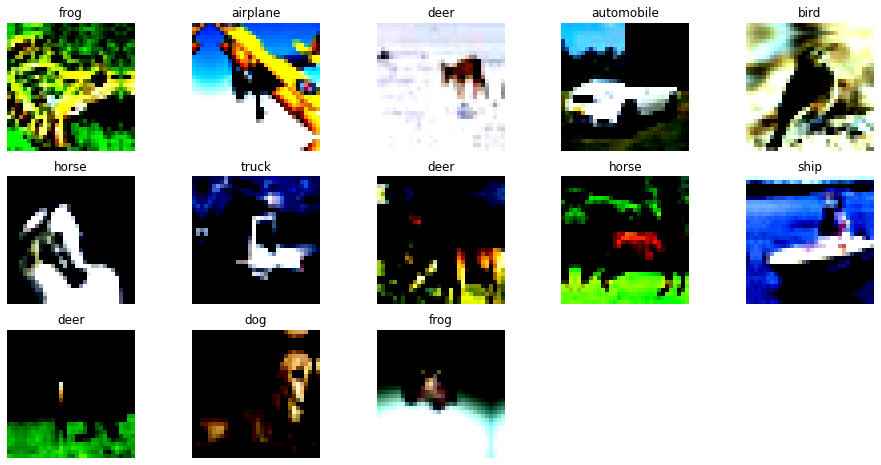

In [13]:
import matplotlib.pyplot as plt # for visualizing images


def show_batch(dataset_loader,label_names,num_images=10):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")


show_batch(trainloader,labels,num_images=13)

### 2. Network
Defining CNN

In [ ]:
'''
ResNet in PyTorch.
This is inspired by https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
'''
ResNet18 Model
'''
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
'''
ResNet34 Model
'''
    return ResNet(BasicBlock, [3, 4, 6, 3])


In [ ]:
# import torch
# import torch.nn as nn # for network
# import torch.nn.functional as F # for forward method

# drop_out_value = 0.1

# class Network(nn.Module):
#     def __init__(self):
#       super(Network,self).__init__() # extending super class method

#       # Input block
#       self.convblock_input= nn.Sequential(
#         nn.Conv2d(3,32,3,padding=1), # In- 3x32x32, Out- 32x32x32, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # CONV BLOCK 1
#       self.convblock1 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )

#       # TRANSITION BLOCK 1
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock1 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x32x32, Out- 32x16x16, RF- 9x9, Jump_in -1, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # CONV BLOCK 2
#       # Depthwise Separable Convolution Layer
#       self.convblock2 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1,groups=32),# In- 32x16x16, Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
#         nn.Conv2d(32,32,1,padding=0), # In-32x16x16 , Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In-32x16x16 , Out-32x16x16 , RF- 17x17, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # TRANSITION BLOCK 2
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock2 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x16x16, Out-32x8x8 , RF- 21x21, Jump_in -2, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
        
      
#       # CONV BLOCK 3
#       # Dilated Convolution Layer
#       self.convblock3 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1,dilation=2),# In- 32x8x8, Out-32x6x6 , RF- 29x29, Jump_in -4, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1), # In-32x6x6 , Out- 32x6x6, RF- 37x37, Jump_in -4, Jump_out -4
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )
      
#       # TRANSITION BLOCK 3
#       # STRIDED CONVOLUTION LAYER
#       self.transitionblock3 = nn.Sequential(
#         nn.Conv2d(32,32,3,stride=2,padding=1), # In-32x6x6 , Out-32x3x3 , RF- 45x45, Jump_in -4, Jump_out -8
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         )   

#       # CONV BLOCK 4
#       # Depthwise Separable Convolution Layer
#       self.convblock4 = nn.Sequential(
#         nn.Conv2d(32,32,3,padding=1), # In- 32x3x3, Out-32x3x3 , RF- 61x61, Jump_in -8, Jump_out -8
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Dropout(drop_out_value)
#         ,
#         nn.Conv2d(32,32,3,padding=1,groups=32), # In-32x3x3 , Out-32x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
#         nn.Conv2d(32,10,1,padding=0) # In- 32x3x3, Out-10x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
#         # , 
#         # nn.ReLU(),
#         # nn.BatchNorm2d(10),
#         # nn.Dropout(drop_out_value)
#         )
      
#       # Output BLOCK 
#       # GAP Layer
#       self.gap = nn.AvgPool2d(3) # In- 10x3x3, Out-10x1x1 , RF- 77x77, Jump_in -8, Jump_out -8


#     def forward(self, x):
#       x = self.convblock_input(x)
#       x = self.convblock1(x)
#       x = self.transitionblock1(x)
#       x = self.convblock2(x)
#       x = self.transitionblock2(x)
#       x = self.convblock3(x)
#       x = self.transitionblock3(x)
#       x = self.convblock4(x)
#       x = self.gap(x)

#       x = x.view(-1, 10)

#       return F.log_softmax(x, dim=1)

#### Model Params
Checking the model summary and number of parameters


In [ ]:
device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Network().to(device)
# print(model)

# !pip install torchsummary
from torchsummary import summary # for model summary and params
summary(model, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1

### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [ ]:
import torch.optim as optim # for optimizer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)

In [ ]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [ ]:
EPOCHS = 170
# EPOCHS = 2

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)



EPOCH: 1


Loss=2.1100752353668213 Batch_id=390 Accuracy=15.57: 100%|██████████| 391/391 [00:36<00:00, 10.64it/s]



Test set: Average loss: 0.0002, Accuracy: 2135/10000 (21.35%)

EPOCH: 2


Loss=1.8324930667877197 Batch_id=390 Accuracy=26.62: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 0.0002, Accuracy: 2867/10000 (28.67%)

EPOCH: 3


Loss=1.7296664714813232 Batch_id=390 Accuracy=34.42: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.0002, Accuracy: 3922/10000 (39.22%)

EPOCH: 4


Loss=1.6016744375228882 Batch_id=390 Accuracy=40.23: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.0001, Accuracy: 4684/10000 (46.84%)

EPOCH: 5


Loss=1.5826642513275146 Batch_id=390 Accuracy=44.55: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]



Test set: Average loss: 0.0001, Accuracy: 4981/10000 (49.81%)

EPOCH: 6


Loss=1.3019081354141235 Batch_id=390 Accuracy=48.26: 100%|██████████| 391/391 [00:33<00:00, 11.76it/s]



Test set: Average loss: 0.0001, Accuracy: 5567/10000 (55.67%)

EPOCH: 7


Loss=1.336268424987793 Batch_id=390 Accuracy=51.87: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s]



Test set: Average loss: 0.0001, Accuracy: 5896/10000 (58.96%)

EPOCH: 8


Loss=1.2847288846969604 Batch_id=390 Accuracy=54.57: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]



Test set: Average loss: 0.0001, Accuracy: 6091/10000 (60.91%)

EPOCH: 9


Loss=0.9921624064445496 Batch_id=390 Accuracy=57.31: 100%|██████████| 391/391 [00:36<00:00, 10.75it/s]



Test set: Average loss: 0.0001, Accuracy: 6380/10000 (63.80%)

EPOCH: 10


Loss=1.1241079568862915 Batch_id=390 Accuracy=58.72: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.0001, Accuracy: 6446/10000 (64.46%)

EPOCH: 11


Loss=0.9309322237968445 Batch_id=390 Accuracy=60.41: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 6594/10000 (65.94%)

EPOCH: 12


Loss=1.0961602926254272 Batch_id=390 Accuracy=61.42: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.0001, Accuracy: 6690/10000 (66.90%)

EPOCH: 13


Loss=0.9292014241218567 Batch_id=390 Accuracy=62.80: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0001, Accuracy: 6910/10000 (69.10%)

EPOCH: 14


Loss=1.0487982034683228 Batch_id=390 Accuracy=63.66: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.0001, Accuracy: 6948/10000 (69.48%)

EPOCH: 15


Loss=1.0363919734954834 Batch_id=390 Accuracy=64.78: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 6959/10000 (69.59%)

EPOCH: 16


Loss=1.011906623840332 Batch_id=390 Accuracy=65.89: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0001, Accuracy: 7170/10000 (71.70%)

EPOCH: 17


Loss=0.85759037733078 Batch_id=390 Accuracy=66.31: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0001, Accuracy: 7200/10000 (72.00%)

EPOCH: 18


Loss=0.9063647389411926 Batch_id=390 Accuracy=67.42: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]



Test set: Average loss: 0.0001, Accuracy: 7363/10000 (73.63%)

EPOCH: 19


Loss=0.8322809934616089 Batch_id=390 Accuracy=68.34: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]



Test set: Average loss: 0.0001, Accuracy: 7367/10000 (73.67%)

EPOCH: 20


Loss=1.085662603378296 Batch_id=390 Accuracy=69.01: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.0001, Accuracy: 7457/10000 (74.57%)

EPOCH: 21


Loss=0.8981949687004089 Batch_id=390 Accuracy=69.48: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0001, Accuracy: 7543/10000 (75.43%)

EPOCH: 22


Loss=1.0171573162078857 Batch_id=390 Accuracy=70.23: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0001, Accuracy: 7683/10000 (76.83%)

EPOCH: 23


Loss=0.993607223033905 Batch_id=390 Accuracy=70.53: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.0001, Accuracy: 7674/10000 (76.74%)

EPOCH: 24


Loss=0.7843819856643677 Batch_id=390 Accuracy=71.13: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0001, Accuracy: 7755/10000 (77.55%)

EPOCH: 25


Loss=0.8446677327156067 Batch_id=390 Accuracy=71.65: 100%|██████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0001, Accuracy: 7727/10000 (77.27%)

EPOCH: 26


Loss=0.8647769689559937 Batch_id=390 Accuracy=72.07: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0001, Accuracy: 7757/10000 (77.57%)

EPOCH: 27


Loss=1.000710368156433 Batch_id=390 Accuracy=72.30: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.0001, Accuracy: 7754/10000 (77.54%)

EPOCH: 28


Loss=0.8049702644348145 Batch_id=390 Accuracy=72.86: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 0.0001, Accuracy: 7834/10000 (78.34%)

EPOCH: 29


Loss=0.7531301379203796 Batch_id=390 Accuracy=73.28: 100%|██████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0001, Accuracy: 7832/10000 (78.32%)

EPOCH: 30


Loss=0.8484224081039429 Batch_id=390 Accuracy=73.34: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.0001, Accuracy: 7945/10000 (79.45%)

EPOCH: 31


Loss=0.6763149499893188 Batch_id=390 Accuracy=73.69: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s]



Test set: Average loss: 0.0001, Accuracy: 7901/10000 (79.01%)

EPOCH: 32


Loss=0.9467731714248657 Batch_id=390 Accuracy=74.38: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0001, Accuracy: 7946/10000 (79.46%)

EPOCH: 33


Loss=0.777999997138977 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0001, Accuracy: 8008/10000 (80.08%)

EPOCH: 34


Loss=0.6753572225570679 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.0001, Accuracy: 8006/10000 (80.06%)

EPOCH: 35


Loss=0.7588441967964172 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.0001, Accuracy: 8014/10000 (80.14%)

EPOCH: 36


Loss=0.8721492886543274 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8010/10000 (80.10%)

EPOCH: 37


Loss=0.9127933382987976 Batch_id=390 Accuracy=75.02: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0001, Accuracy: 8044/10000 (80.44%)

EPOCH: 38


Loss=0.5404258966445923 Batch_id=390 Accuracy=75.53: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.0001, Accuracy: 8046/10000 (80.46%)

EPOCH: 39


Loss=0.5940162539482117 Batch_id=390 Accuracy=75.65: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]



Test set: Average loss: 0.0001, Accuracy: 8043/10000 (80.43%)

EPOCH: 40


Loss=0.6228832006454468 Batch_id=390 Accuracy=75.98: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 0.0001, Accuracy: 8095/10000 (80.95%)

EPOCH: 41


Loss=0.7573458552360535 Batch_id=390 Accuracy=76.13: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0001, Accuracy: 8110/10000 (81.10%)

EPOCH: 42


Loss=0.7448878884315491 Batch_id=390 Accuracy=76.15: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0001, Accuracy: 8070/10000 (80.70%)

EPOCH: 43


Loss=0.8797130584716797 Batch_id=390 Accuracy=76.23: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.0001, Accuracy: 8150/10000 (81.50%)

EPOCH: 44


Loss=0.8369450569152832 Batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8151/10000 (81.51%)

EPOCH: 45


Loss=0.8896807432174683 Batch_id=390 Accuracy=76.67: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]



Test set: Average loss: 0.0001, Accuracy: 8142/10000 (81.42%)

EPOCH: 46


Loss=0.7911389470100403 Batch_id=390 Accuracy=77.00: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.0001, Accuracy: 8170/10000 (81.70%)

EPOCH: 47


Loss=0.6688029170036316 Batch_id=390 Accuracy=76.87: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]



Test set: Average loss: 0.0001, Accuracy: 8209/10000 (82.09%)

EPOCH: 48


Loss=0.6459117531776428 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8228/10000 (82.28%)

EPOCH: 49


Loss=0.5098927617073059 Batch_id=390 Accuracy=77.46: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]



Test set: Average loss: 0.0001, Accuracy: 8172/10000 (81.72%)

EPOCH: 50


Loss=0.6137790679931641 Batch_id=390 Accuracy=77.11: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8210/10000 (82.10%)

EPOCH: 51


Loss=0.8761876821517944 Batch_id=390 Accuracy=77.52: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.0000, Accuracy: 8226/10000 (82.26%)

EPOCH: 52


Loss=0.5521502494812012 Batch_id=390 Accuracy=77.48: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]



Test set: Average loss: 0.0001, Accuracy: 8257/10000 (82.57%)

EPOCH: 53


Loss=0.6911195516586304 Batch_id=390 Accuracy=77.84: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0001, Accuracy: 8260/10000 (82.60%)

EPOCH: 54


Loss=0.47639209032058716 Batch_id=390 Accuracy=78.29: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8303/10000 (83.03%)

EPOCH: 55


Loss=0.5730563998222351 Batch_id=390 Accuracy=77.83: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s]



Test set: Average loss: 0.0001, Accuracy: 8278/10000 (82.78%)

EPOCH: 56


Loss=0.6849583983421326 Batch_id=390 Accuracy=78.18: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8272/10000 (82.72%)

EPOCH: 57


Loss=0.5598973035812378 Batch_id=390 Accuracy=78.29: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8292/10000 (82.92%)

EPOCH: 58


Loss=0.6233875751495361 Batch_id=390 Accuracy=78.12: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8329/10000 (83.29%)

EPOCH: 59


Loss=0.4817434847354889 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:36<00:00, 10.75it/s]



Test set: Average loss: 0.0001, Accuracy: 8334/10000 (83.34%)

EPOCH: 60


Loss=0.905829906463623 Batch_id=390 Accuracy=78.28: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8261/10000 (82.61%)

EPOCH: 61


Loss=0.5338864922523499 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8297/10000 (82.97%)

EPOCH: 62


Loss=0.6979466676712036 Batch_id=390 Accuracy=78.60: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8323/10000 (83.23%)

EPOCH: 63


Loss=0.6289762258529663 Batch_id=390 Accuracy=78.82: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0000, Accuracy: 8351/10000 (83.51%)

EPOCH: 64


Loss=0.5821845531463623 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8335/10000 (83.35%)

EPOCH: 65


Loss=0.6272561550140381 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8311/10000 (83.11%)

EPOCH: 66


Loss=0.5649338364601135 Batch_id=390 Accuracy=79.06: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8357/10000 (83.57%)

EPOCH: 67


Loss=0.5184321403503418 Batch_id=390 Accuracy=79.19: 100%|██████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8343/10000 (83.43%)

EPOCH: 68


Loss=0.4706047475337982 Batch_id=390 Accuracy=79.32: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.0000, Accuracy: 8349/10000 (83.49%)

EPOCH: 69


Loss=0.4225758910179138 Batch_id=390 Accuracy=79.23: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s]



Test set: Average loss: 0.0000, Accuracy: 8341/10000 (83.41%)

EPOCH: 70


Loss=0.6062684059143066 Batch_id=390 Accuracy=79.46: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8395/10000 (83.95%)

EPOCH: 71


Loss=0.46356940269470215 Batch_id=390 Accuracy=79.59: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0000, Accuracy: 8387/10000 (83.87%)

EPOCH: 72


Loss=0.4742688238620758 Batch_id=390 Accuracy=79.50: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8382/10000 (83.82%)

EPOCH: 73


Loss=0.8694382905960083 Batch_id=390 Accuracy=79.56: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8363/10000 (83.63%)

EPOCH: 74


Loss=0.552568793296814 Batch_id=390 Accuracy=79.79: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8371/10000 (83.71%)

EPOCH: 75


Loss=0.4966360628604889 Batch_id=390 Accuracy=79.68: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]



Test set: Average loss: 0.0000, Accuracy: 8375/10000 (83.75%)

EPOCH: 76


Loss=0.6944774389266968 Batch_id=390 Accuracy=79.87: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8375/10000 (83.75%)

EPOCH: 77


Loss=0.5010042190551758 Batch_id=390 Accuracy=79.78: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8398/10000 (83.98%)

EPOCH: 78


Loss=0.48219817876815796 Batch_id=390 Accuracy=80.16: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 0.0000, Accuracy: 8415/10000 (84.15%)

EPOCH: 79


Loss=0.6339697241783142 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8416/10000 (84.16%)

EPOCH: 80


Loss=0.5676466226577759 Batch_id=390 Accuracy=80.06: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8415/10000 (84.15%)

EPOCH: 81


Loss=0.5503158569335938 Batch_id=390 Accuracy=80.14: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8406/10000 (84.06%)

EPOCH: 82


Loss=0.5068295001983643 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8427/10000 (84.27%)

EPOCH: 83


Loss=0.6450968384742737 Batch_id=390 Accuracy=80.47: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0000, Accuracy: 8423/10000 (84.23%)

EPOCH: 84


Loss=0.6636596918106079 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8393/10000 (83.93%)

EPOCH: 85


Loss=0.5309664607048035 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8431/10000 (84.31%)

EPOCH: 86


Loss=0.7293575406074524 Batch_id=390 Accuracy=80.39: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8437/10000 (84.37%)

EPOCH: 87


Loss=0.39849331974983215 Batch_id=390 Accuracy=80.61: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0000, Accuracy: 8473/10000 (84.73%)

EPOCH: 88


Loss=0.5614215731620789 Batch_id=390 Accuracy=80.81: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8491/10000 (84.91%)

EPOCH: 89


Loss=0.5894009470939636 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8438/10000 (84.38%)

EPOCH: 90


Loss=0.6065171360969543 Batch_id=390 Accuracy=80.71: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8501/10000 (85.01%)

EPOCH: 91


Loss=0.5354758501052856 Batch_id=390 Accuracy=81.03: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8469/10000 (84.69%)

EPOCH: 92


Loss=0.7374811768531799 Batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8485/10000 (84.85%)

EPOCH: 93


Loss=0.6522011160850525 Batch_id=390 Accuracy=80.81: 100%|██████████| 391/391 [00:36<00:00, 10.62it/s]



Test set: Average loss: 0.0000, Accuracy: 8512/10000 (85.12%)

EPOCH: 94


Loss=0.3890395760536194 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8478/10000 (84.78%)

EPOCH: 95


Loss=0.8330539464950562 Batch_id=390 Accuracy=80.76: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]



Test set: Average loss: 0.0000, Accuracy: 8463/10000 (84.63%)

EPOCH: 96


Loss=0.6541143655776978 Batch_id=390 Accuracy=80.85: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8492/10000 (84.92%)

EPOCH: 97


Loss=0.6267529726028442 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8486/10000 (84.86%)

EPOCH: 98


Loss=0.529616117477417 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8487/10000 (84.87%)

EPOCH: 99


Loss=0.5493414998054504 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.0000, Accuracy: 8517/10000 (85.17%)

EPOCH: 100


Loss=0.42842382192611694 Batch_id=390 Accuracy=81.23: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8505/10000 (85.05%)

EPOCH: 101


Loss=0.6251036524772644 Batch_id=390 Accuracy=81.01: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8495/10000 (84.95%)

EPOCH: 102


Loss=0.5654088258743286 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.0000, Accuracy: 8522/10000 (85.22%)

EPOCH: 103


Loss=0.48576268553733826 Batch_id=390 Accuracy=81.24: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0000, Accuracy: 8514/10000 (85.14%)

EPOCH: 104


Loss=0.596933126449585 Batch_id=390 Accuracy=81.46: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8489/10000 (84.89%)

EPOCH: 105


Loss=0.5496557354927063 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8516/10000 (85.16%)

EPOCH: 106


Loss=0.49730730056762695 Batch_id=390 Accuracy=81.37: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.0000, Accuracy: 8525/10000 (85.25%)

EPOCH: 107


Loss=0.5378270745277405 Batch_id=390 Accuracy=81.60: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8471/10000 (84.71%)

EPOCH: 108


Loss=0.4324165880680084 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.0000, Accuracy: 8512/10000 (85.12%)

EPOCH: 109


Loss=0.6670854091644287 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8534/10000 (85.34%)

EPOCH: 110


Loss=0.693191409111023 Batch_id=390 Accuracy=81.64: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8522/10000 (85.22%)

EPOCH: 111


Loss=0.5875498652458191 Batch_id=390 Accuracy=81.44: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0000, Accuracy: 8537/10000 (85.37%)

EPOCH: 112


Loss=0.7472817301750183 Batch_id=390 Accuracy=81.64: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 0.0000, Accuracy: 8535/10000 (85.35%)

EPOCH: 113


Loss=0.5139240622520447 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0000, Accuracy: 8532/10000 (85.32%)

EPOCH: 114


Loss=0.5051407814025879 Batch_id=390 Accuracy=81.76: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0000, Accuracy: 8521/10000 (85.21%)

EPOCH: 115


Loss=0.6171163320541382 Batch_id=390 Accuracy=81.78: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8550/10000 (85.50%)

EPOCH: 116


Loss=0.641224205493927 Batch_id=390 Accuracy=81.95: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.0000, Accuracy: 8563/10000 (85.63%)

EPOCH: 117


Loss=0.5378371477127075 Batch_id=390 Accuracy=81.84: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Test set: Average loss: 0.0000, Accuracy: 8537/10000 (85.37%)

EPOCH: 118


Loss=0.5849941372871399 Batch_id=390 Accuracy=81.81: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8548/10000 (85.48%)

EPOCH: 119


Loss=0.5721490979194641 Batch_id=390 Accuracy=81.63: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8580/10000 (85.80%)

EPOCH: 120


Loss=0.5534623861312866 Batch_id=390 Accuracy=81.80: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8594/10000 (85.94%)

EPOCH: 121


Loss=0.7381659150123596 Batch_id=390 Accuracy=82.35: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8522/10000 (85.22%)

EPOCH: 122


Loss=0.5571944713592529 Batch_id=390 Accuracy=82.13: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0000, Accuracy: 8602/10000 (86.02%)

EPOCH: 123


Loss=0.31585830450057983 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0000, Accuracy: 8581/10000 (85.81%)

EPOCH: 124


Loss=0.5475362539291382 Batch_id=390 Accuracy=82.36: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8600/10000 (86.00%)

EPOCH: 125


Loss=0.5096850991249084 Batch_id=390 Accuracy=82.12: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8579/10000 (85.79%)

EPOCH: 126


Loss=0.6318669319152832 Batch_id=390 Accuracy=81.90: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0000, Accuracy: 8547/10000 (85.47%)

EPOCH: 127


Loss=0.589290976524353 Batch_id=390 Accuracy=82.26: 100%|██████████| 391/391 [00:36<00:00, 10.65it/s]



Test set: Average loss: 0.0000, Accuracy: 8590/10000 (85.90%)

EPOCH: 128


Loss=0.45014625787734985 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 0.0000, Accuracy: 8604/10000 (86.04%)

EPOCH: 129


Loss=0.578066349029541 Batch_id=390 Accuracy=82.21: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s]



Test set: Average loss: 0.0000, Accuracy: 8586/10000 (85.86%)

EPOCH: 130


Loss=0.40618592500686646 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0000, Accuracy: 8592/10000 (85.92%)

EPOCH: 131


Loss=0.4067172110080719 Batch_id=390 Accuracy=82.55: 100%|██████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8550/10000 (85.50%)

EPOCH: 132


Loss=0.4894019067287445 Batch_id=390 Accuracy=81.99: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8578/10000 (85.78%)

EPOCH: 133


Loss=0.6386643648147583 Batch_id=390 Accuracy=82.38: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Test set: Average loss: 0.0000, Accuracy: 8613/10000 (86.13%)

EPOCH: 134


Loss=0.55823814868927 Batch_id=390 Accuracy=82.29: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8558/10000 (85.58%)

EPOCH: 135


Loss=0.4146374762058258 Batch_id=390 Accuracy=82.17: 100%|██████████| 391/391 [00:36<00:00, 10.66it/s]



Test set: Average loss: 0.0000, Accuracy: 8613/10000 (86.13%)

EPOCH: 136


Loss=0.43347206711769104 Batch_id=390 Accuracy=82.73: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.0000, Accuracy: 8574/10000 (85.74%)

EPOCH: 137


Loss=0.5394539833068848 Batch_id=390 Accuracy=82.36: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8618/10000 (86.18%)

EPOCH: 138


Loss=0.7387709617614746 Batch_id=390 Accuracy=82.54: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.0000, Accuracy: 8589/10000 (85.89%)

EPOCH: 139


Loss=0.5824819207191467 Batch_id=390 Accuracy=82.51: 100%|██████████| 391/391 [00:36<00:00, 10.69it/s]



Test set: Average loss: 0.0000, Accuracy: 8587/10000 (85.87%)

EPOCH: 140


Loss=0.6009189486503601 Batch_id=390 Accuracy=82.49: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.0000, Accuracy: 8594/10000 (85.94%)

EPOCH: 141


Loss=0.5074015855789185 Batch_id=390 Accuracy=82.74: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Test set: Average loss: 0.0000, Accuracy: 8585/10000 (85.85%)

EPOCH: 142


Loss=0.35621801018714905 Batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8601/10000 (86.01%)

EPOCH: 143


Loss=0.49727287888526917 Batch_id=390 Accuracy=82.81: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8613/10000 (86.13%)

EPOCH: 144


Loss=0.5703905820846558 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:33<00:00, 11.50it/s]



Test set: Average loss: 0.0000, Accuracy: 8627/10000 (86.27%)

EPOCH: 145


Loss=0.5759248733520508 Batch_id=390 Accuracy=82.84: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8596/10000 (85.96%)

EPOCH: 146


Loss=0.42697739601135254 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]



Test set: Average loss: 0.0000, Accuracy: 8597/10000 (85.97%)

EPOCH: 147


Loss=0.42437344789505005 Batch_id=390 Accuracy=82.40: 100%|██████████| 391/391 [00:36<00:00, 10.67it/s]



Test set: Average loss: 0.0000, Accuracy: 8598/10000 (85.98%)

EPOCH: 148


Loss=0.6247614026069641 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]



Test set: Average loss: 0.0000, Accuracy: 8635/10000 (86.35%)

EPOCH: 149


Loss=0.5188658237457275 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8592/10000 (85.92%)

EPOCH: 150


Loss=0.6267871260643005 Batch_id=390 Accuracy=82.71: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 0.0000, Accuracy: 8639/10000 (86.39%)

EPOCH: 151


Loss=0.5476226210594177 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Test set: Average loss: 0.0000, Accuracy: 8570/10000 (85.70%)

EPOCH: 152


Loss=0.40741491317749023 Batch_id=390 Accuracy=82.82: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 0.0000, Accuracy: 8590/10000 (85.90%)

EPOCH: 153


Loss=0.38875389099121094 Batch_id=390 Accuracy=82.79: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8599/10000 (85.99%)

EPOCH: 154


Loss=0.4738622307777405 Batch_id=390 Accuracy=82.94: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.0000, Accuracy: 8622/10000 (86.22%)

EPOCH: 155


Loss=0.44556981325149536 Batch_id=390 Accuracy=82.98: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0000, Accuracy: 8620/10000 (86.20%)

EPOCH: 156


Loss=0.5339500308036804 Batch_id=390 Accuracy=83.13: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]



Test set: Average loss: 0.0000, Accuracy: 8634/10000 (86.34%)

EPOCH: 157


Loss=0.5711321234703064 Batch_id=390 Accuracy=83.12: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s]



Test set: Average loss: 0.0000, Accuracy: 8583/10000 (85.83%)

EPOCH: 158


Loss=0.4286385178565979 Batch_id=390 Accuracy=83.29: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.0000, Accuracy: 8608/10000 (86.08%)

EPOCH: 159


Loss=0.3483412265777588 Batch_id=390 Accuracy=83.08: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8623/10000 (86.23%)

EPOCH: 160


Loss=0.4548174738883972 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.0000, Accuracy: 8621/10000 (86.21%)

EPOCH: 161


Loss=0.4862020015716553 Batch_id=390 Accuracy=83.02: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Test set: Average loss: 0.0000, Accuracy: 8609/10000 (86.09%)

EPOCH: 162


Loss=0.4255538582801819 Batch_id=390 Accuracy=83.03: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.0000, Accuracy: 8627/10000 (86.27%)

EPOCH: 163


Loss=0.695776104927063 Batch_id=390 Accuracy=83.22: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8621/10000 (86.21%)

EPOCH: 164


Loss=0.4166873097419739 Batch_id=390 Accuracy=83.32: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.0000, Accuracy: 8601/10000 (86.01%)

EPOCH: 165


Loss=0.5137770175933838 Batch_id=390 Accuracy=83.17: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s]



Test set: Average loss: 0.0000, Accuracy: 8601/10000 (86.01%)

EPOCH: 166


Loss=0.5387396216392517 Batch_id=390 Accuracy=83.35: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]



Test set: Average loss: 0.0000, Accuracy: 8613/10000 (86.13%)

EPOCH: 167


Loss=0.42475754022598267 Batch_id=390 Accuracy=83.24: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s]



Test set: Average loss: 0.0000, Accuracy: 8597/10000 (85.97%)

EPOCH: 168


Loss=0.5020042061805725 Batch_id=390 Accuracy=83.21: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.0000, Accuracy: 8627/10000 (86.27%)

EPOCH: 169


Loss=0.7004002332687378 Batch_id=390 Accuracy=83.18: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s]



Test set: Average loss: 0.0000, Accuracy: 8627/10000 (86.27%)

EPOCH: 170


Loss=0.5940354466438293 Batch_id=390 Accuracy=83.43: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.0000, Accuracy: 8626/10000 (86.26%)



### 4. Checking results

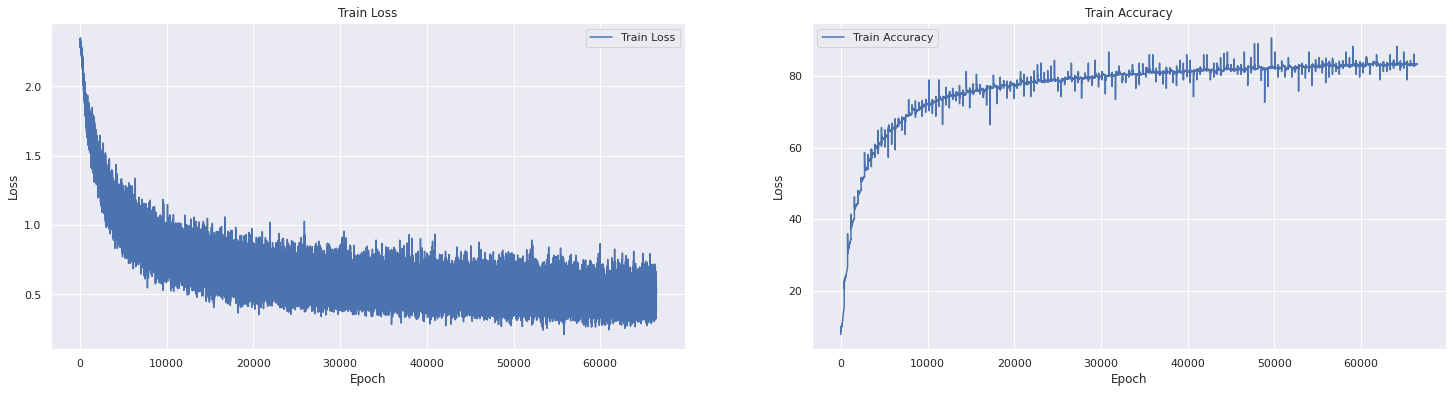

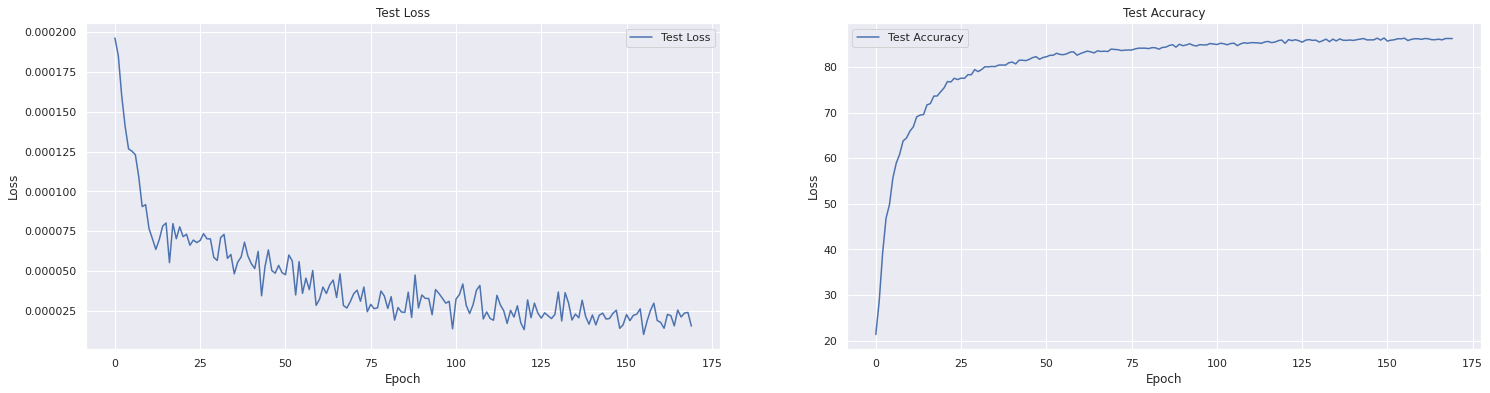

In [ ]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")
    
    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")
    
    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")
    
    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")
    
    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   frog   car  frog   cat   car
Predicted:   frog   car  frog   cat   car


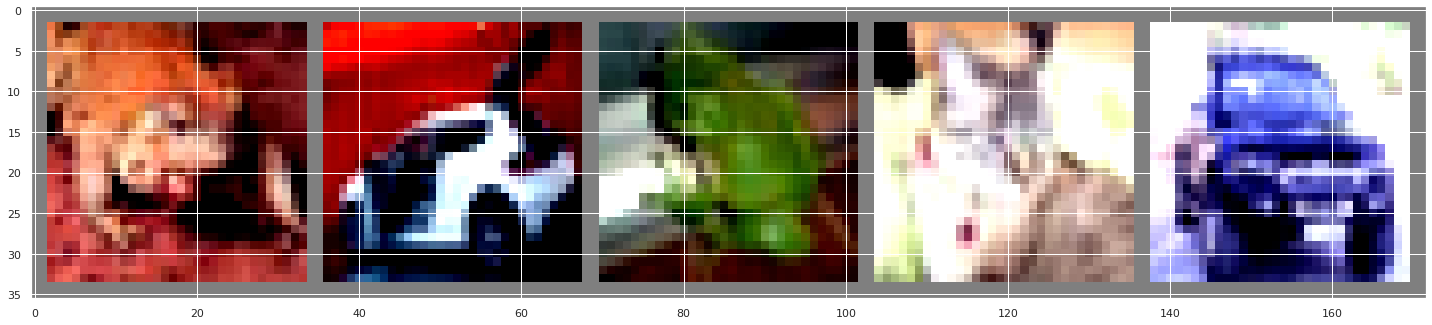

In [ ]:
def show_predicted_actual(model, device, dataset, classes):
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# print images
	imshow(torchvision.utils.make_grid(images[img_list]))
	print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	images = images.to(device)
	outputs = model(images)

	_, predicted = torch.max(outputs, 1)
	print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in img_list))
 

show_predicted_actual(model, device, testloader, classes)


In [ ]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
      
evaluate_classwise_accuracy(model, device, classes, testloader)


Accuracy of plane : 82 %
Accuracy of   car : 100 %
Accuracy of  bird : 81 %
Accuracy of   cat : 82 %
Accuracy of  deer : 88 %
Accuracy of   dog : 78 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %
